# Bioacoustic analysis of DAS-recorded data

Author: [Léa Bouffaut](mailto:lb736'cornell.edu)
https://www.birds.cornell.edu/ccb/lea-bouffaut/


OptaSense QuantX data

### Initialization of the libraries

In [4]:
# Get the DAS4Whales package
!pip3 install 'git+https://github.com/leabouffaut/DAS4Whales.git'

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/leabouffaut/DAS4Whales.git to /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-9eu5mi7c
  Running command git clone --filter=blob:none --quiet https://github.com/leabouffaut/DAS4Whales.git /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-9eu5mi7c
  Resolved https://github.com/leabouffaut/DAS4Whales.git to commit 02e437c2535586362df30e634a8a3c419bef7b53
  Preparing metadata (setup.py) ... done


## Download a .hdf5 file from the OOI DAS experiment
Experiment information can be found at:  https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/

Files are ~850 MB so the download can take a while

Comment the section below if you already have a DAS file in your path

In [6]:
#import wget
#url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
#      'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/' \
#      'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'
#das_example_file = wget.download(url) # This re-download each we run the code
#print(['Downloaded: ', das_example_file])

## Get information on the DAS data

In [10]:
import das4whales as dw
import scipy.signal as sp
import numpy as np

# Read HDF5 files and accessing metadata
filename = 'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'

# Get the acquisition parameters for the data folder
fs, dx, nx, ns, scale_factor = dw.das_data.get_acquisition_parameters(filename)

print('Sampling frequency: ', fs, ' Hz')
print('Channel spacing: ', dx, ' m')
print('Number of channels: ', nx)
print('Number of time samples: ', ns)

Sampling frequency:  200.0  Hz
Channel spacing:  2.0419047  m
Number of channels:  32600
Number of time samples:  12000


## Select the desired channels

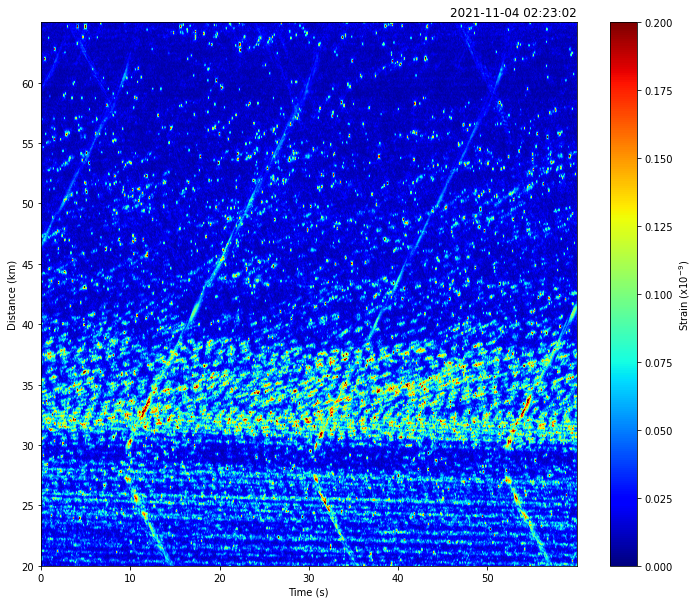

In [7]:
selected_channels_m = [20000, 65000, 10]  # list of values in meters corresponding to the starting,
                                          # ending and step wanted channels along the FO Cable
                                          # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                          # in meters

selected_channels = [int(np.floor(selected_channels_m / dx)) for selected_channels_m in
                     selected_channels_m]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                           # channels along the FO Cable
                                           # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                           # numbers
# Create conditioning for the signal
# Create high-pass filter
sos_hpfilt = dw.preprocess.butterworth_filter([2, 5, 'hp'], fs)

# Create band-pass filter for the TX plots
sos_bpfilt = dw.preprocess.butterworth_filter([5, [10, 30], 'bp'], fs)

# Load DAS data
tr, tx, dist, fileBeginTimeUTC = dw.das_data.load_das_data(filename, fs, dx, selected_channels, scale_factor)

# apply the high-pass filter
trf = sp.sosfiltfilt(sos_hpfilt, tr, axis=1)

# FK filter
# loop is taking 1.4s - not much to crunch there
trf_fk = dw.preprocess.fk_filtering(trf, selected_channels, dx, fs, cmin=1450, cmax=3000)

# TX-plot of the FK filtered data, additionally band-pass filtered
trff = sp.sosfiltfilt(sos_bpfilt, trf_fk, axis=1)

# start_time = time.time()
dw.plot.plot_tx(trff, tx, dist, fs, selected_channels, fileBeginTimeUTC)
